# 13.1 Stepwise Functions

## The Dataset

We will use the Mid-Atlantic Wage Dataset from the [ISLP library](https://islp.readthedocs.io/en/latest/) to showcase fitting stepwise functions. Our research goal is to predict `wage` for different `age` ranges by taking the average wage within each bin as our estimate for prediction.

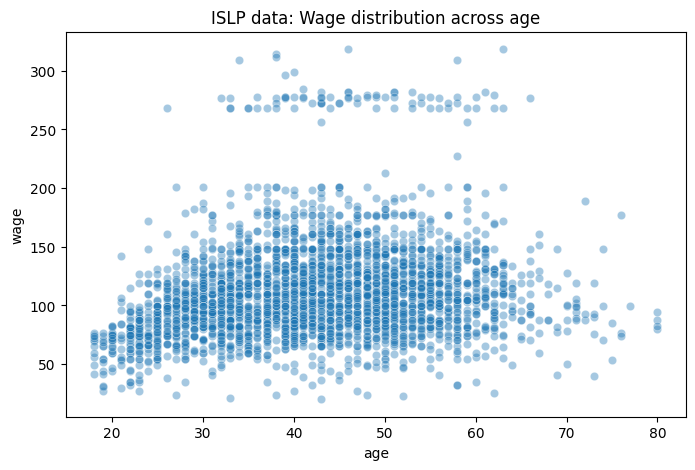

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import patsy
from ISLP import load_data

# Load and plot the data
df = load_data('Wage')

fig, ax = plt.subplots(figsize=(8,5))
sns.scatterplot(data=df, x='age', y='wage', alpha=0.4, ax=ax)       
ax.set_title("ISLP data: Wage distribution across age");

## Fitting a stepwise function

To fit a stepwise funtion, we first need to get cut points for our predictor variable `age`. For example, we can decide to split our data into 4 equal parts:

In [2]:
bins = pd.cut(df['age'], 4)
print(bins)

0       (17.938, 33.5]
1       (17.938, 33.5]
2         (33.5, 49.0]
3         (33.5, 49.0]
4         (49.0, 64.5]
             ...      
2995      (33.5, 49.0]
2996    (17.938, 33.5]
2997    (17.938, 33.5]
2998    (17.938, 33.5]
2999      (49.0, 64.5]
Name: age, Length: 3000, dtype: category
Categories (4, interval[float64, right]): [(17.938, 33.5] < (33.5, 49.0] < (49.0, 64.5] < (64.5, 80.0]]


The output provides us with intervals for evenly sized bins of `age`. We can use the upper value of each interval to get cut points for our stepwise function. We then use the `dmatrix` function to create a design matrix:

In [3]:
transformed_age = patsy.dmatrix("bs(age, knots=(33.5, 49, 64.5), degree=0)",
                                data={"age": df['age']},
                                return_type='dataframe')

When you specify `"bs(age, ...)"`, you tell `dmatrix` to transform age using B-spline basis functions. These basis functions segment the variable age into piecewise polynomials defined by the specified knots and degree. When you set degree to zero, it creates piecewise constant functions, meaning the resulting function is a step function consisting of only horizontal segments.

### Fitting the model

Once we have the age in our design matrix, we can fit the model like a normal categorical regression model:

In [4]:
model = sm.OLS(df['wage'], transformed_age)
model_fit = model.fit()

print(model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     66.56
Date:                Wed, 09 Apr 2025   Prob (F-statistic):           1.16e-41
Time:                        08:53:29   Log-Likelihood:                -15353.
No. Observations:                3000   AIC:                         3.071e+04
Df Residuals:                    2996   BIC:                         3.074e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                   coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------

The summary tells us:

- The average wage in bin 1 within the age range from 17.9 to 33.5 years equals
to $94.16k per year.
- The wage difference in bin 2 (i.e., between 33.5 and 49 years) as compared with
bin 1 equals to $23.93k per year.
- The wage difference in bin 3 (i.e., between 49 and 64.5 years) as compared with bin 1 equals to $23.89k per year.
- The wage difference in bin 4 (i.e., between 64.5 and 80.1 years) as compared with bin 1 equals to $7.64k per year.

The second and the third bin differ significantly from the first bin. The third bin does not differ significantly from the first one (p = .126)

In summary, the model suggests that wages vary with age, but the relationship is not the same across all age groups. Wages appear to increase with age up to a point, but the increase is not statistically significant for the oldest age group in this sample. 

### Plotting the model

We can also plot the model. Note that bin 2 and 3 have very similar estimates which leads to an indistinguishable difference between $Y$ values in the second bin and $Y$ values in the third.

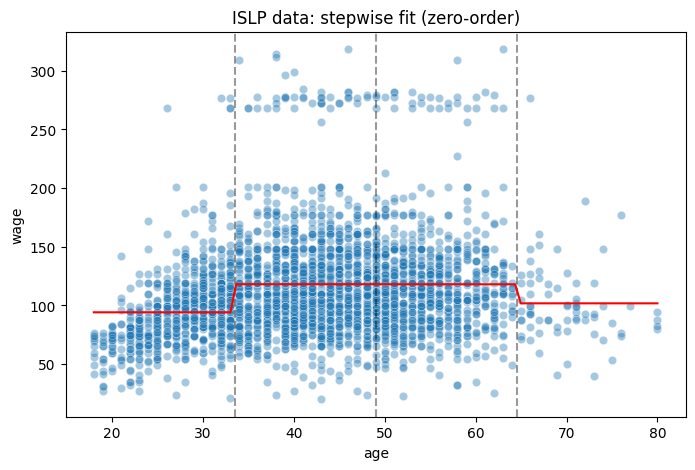

In [5]:
# Plot the model
fig, ax = plt.subplots(figsize=(8,5))

# Generate age values for predictions and transform using the spline basis
xp = np.linspace(df['age'].min(), df['age'].max(), 100)
xp_trans = patsy.dmatrix("bs(xp, knots=(33.5, 49, 64.5), degree=0)",
                         data={"xp": xp},
                         return_type='dataframe')

# Use model fitted before to predict wages for generated age values
predictions = model_fit.predict(xp_trans)

# Plot the original data and the model fit
sns.scatterplot(data=df, x="age", y="wage", alpha=0.4, ax=ax)
ax.axvline(33.5, linestyle='--', alpha=0.4, color="black")      # Cut point 1
ax.axvline(49, linestyle='--', alpha=0.4, color="black")        # Cut point 2
ax.axvline(64.5, linestyle='--', alpha=0.4, color="black")      # Cut point 3
ax.plot(xp, predictions, color='red')
ax.set_title("ISLP data: stepwise fit (zero-order)");